<a href="https://colab.research.google.com/github/roberto-dionisio/introPyTorch/blob/main/basic_convolutional_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#We gotta convert MNIST image files into 4 dim tensors (# of images, Height, width, color channel)
transform = transforms.ToTensor()
#we need to set training and test data.
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.87MB/s]


In [3]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: /cnn_data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: /cnn_data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [6]:
#batches are small set of images of whatever data type you r using
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

(torch.Size([1, 28, 28]), <matplotlib.image.AxesImage at 0x794bcf051cd0>)

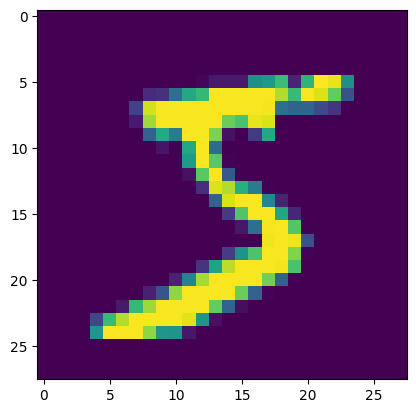

In [15]:
#Define CNN, 2 in this example, atm it is just an example then we will build the actual model
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
conv2 = nn.Conv2d(in_channels=6, out_channels = 16, kernel_size=3, stride=1)

#Grab 1 MNIST image/record
for i, (X_train, y_traind) in enumerate(train_data):
  break

X_train.shape, plt.imshow(X_train.reshape(28,28)) #(1,28,28) -> (28,28)

In [18]:
x = X_train.view(1,1,28,28)
x.shape #to a 4d batch, 1 batch of 1 image of 28x18 image

torch.Size([1, 1, 28, 28])

In [19]:
#1st convolution
x = F.relu(conv1(x)) #Rectified linear unit for our activation function
x.shape #1 single image, 6 filters , 26 x 26 is the image cause we put the padding off, outer pixel do not contain any pixel on

torch.Size([1, 6, 26, 26])

In [20]:
# pass through the pooling layer
x = F.max_pool2d(x, 2,2) #kernel of 2 and stride of 2
x.shape # 13 13 it is ppoling by 2

torch.Size([1, 6, 13, 13])

In [21]:
#2nd conv layer: conv ->pool-conv->pool
x = F.relu(conv2(x))
x.shape #16 features , from 13 to 11 due to the padding being turned off

torch.Size([1, 16, 11, 11])

In [23]:
x = F.max_pool2d(x, 2,2)
x.shape #5x5: 11/2= 5.5 and it has been round down cause you cannot "invent" data lol

torch.Size([1, 16, 2, 2])

In [30]:
#MODEL TIME
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels = 16, kernel_size=3, stride=1)
    #Fully connected layers
    self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=64)
    self.fc3 = nn.Linear(in_features=64, out_features=10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2) #2x2 kernel and stride 2
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)
    #flatten it out
    X = X.view(-1, 16*5*5) # -1 so we can vary the batch size
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1) #output

#instanciate
torch.manual_seed(41)

model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [31]:
#Loss function optimizer
criterion  = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
import time
start_time = time.time()

#Variables to track stuff
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct=[]

#For loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  #Train
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 #start batches at 1
    y_pred = model(X_train) # get predictions from our trining set, Notflattened input m,ust be 2d as we have defined our model
    loss = criterion(y_pred, y_train)
    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the ifirst point(check not sure)
    batch_corr = (predicted == y_train).sum() #how many we gort corrected from this specific batch
    trn_corr += batch_corr

    #UPDATE PARS
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #print res
    if b%600 == 0:
      print(f'Epoch: {i} Batch: {b}  Loss: {loss.item()}')
  train_losses.append(loss)
  train_correct.append(trn_corr)
  #TESTING
  with torch.no_grad():
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

cur_time = time.time()

elapsed_time = cur_time - start_time
print(f'Training took {elapsed_time/60} minutes')

Epoch: 0 Batch: 600  Loss: 0.09838603436946869
Epoch: 0 Batch: 1200  Loss: 0.1974300891160965
Epoch: 0 Batch: 1800  Loss: 0.02280254103243351
Epoch: 0 Batch: 2400  Loss: 0.39020782709121704
Epoch: 0 Batch: 3000  Loss: 0.02321077324450016
Epoch: 0 Batch: 3600  Loss: 0.01658933237195015
Epoch: 0 Batch: 4200  Loss: 0.00989486463367939
Epoch: 0 Batch: 4800  Loss: 0.3259510397911072
Epoch: 0 Batch: 5400  Loss: 0.0012063378235325217
Epoch: 0 Batch: 6000  Loss: 0.016793761402368546
Epoch: 1 Batch: 600  Loss: 0.04296751320362091
Epoch: 1 Batch: 1200  Loss: 0.002424773061648011
Epoch: 1 Batch: 1800  Loss: 0.0535711832344532
Epoch: 1 Batch: 2400  Loss: 0.011568969115614891
Epoch: 1 Batch: 3000  Loss: 0.016909927129745483
Epoch: 1 Batch: 3600  Loss: 0.04163137823343277
Epoch: 1 Batch: 4200  Loss: 0.006586598698049784
Epoch: 1 Batch: 4800  Loss: 0.0006105502834543586
Epoch: 1 Batch: 5400  Loss: 0.005740298889577389
Epoch: 1 Batch: 6000  Loss: 0.09833849966526031
Epoch: 2 Batch: 600  Loss: 0.043597

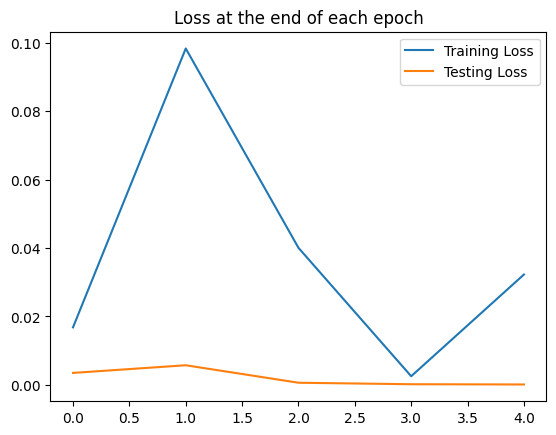

In [44]:
train_lossess = [tl.item() for tl in train_losses]
plt.plot(train_lossess, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss at the end of each epoch')
plt.legend()

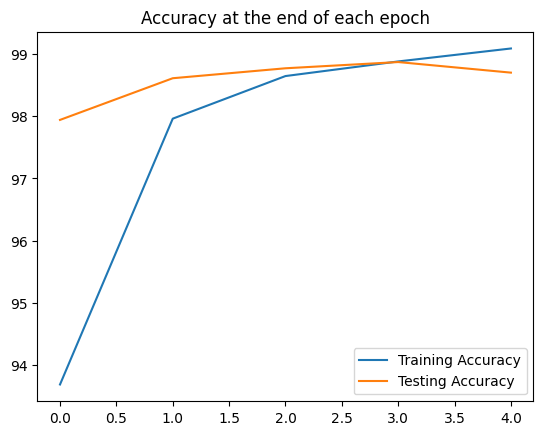

In [51]:
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Testing Accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [55]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()
  print(f'Test Accuracy: {correct/10000}')
correct.item()

Test Accuracy: 0.9869999885559082


9870

In [60]:
#Grab an image
test_data[400]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

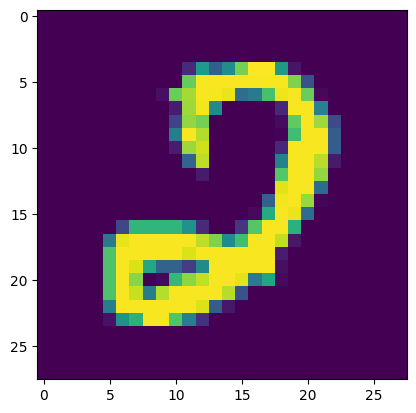

In [61]:
plt.imshow(test_data[400][0].reshape(28,28))

In [62]:
#pass the image
model.eval()

with torch.no_grad():
  out = model(test_data[400][0].view(1,1,28,28)) #batch of 1, 1 color, 28x28 image

In [63]:
out

tensor([[-5.7641e+00, -1.1627e+01, -1.2338e-02, -6.4235e+00, -1.4143e+01,
         -9.4247e+00, -1.6273e+01, -8.6561e+00, -5.1296e+00, -6.6321e+00]])

In [66]:
torch.max(out), out.argmax()

(tensor(-0.0123), tensor(2))